# Predicting Category of an incident based on the information provided by the customer

A University IT department receives help request in the form of IT tickets with a short description of the problem and addtional comments. The tickets are then passed to a human to be manually categoried into the appropriate department which will then handle the help request. This process is labor intensive and can be prone to error.

In this notebook, I will be automating the process of labling each help request into their appropriate department.

The input for this project is a CSV file containing the help request emails sent to an IT technician that has been prelabled manually. The output will be the category for the help request. 

**Table of Content**
 - [First look at the data](#First-look-at-the-data)
 - [Data Cleaning](#Data-Cleaning)
 - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
 - [Modeling](#Modeling)
 - Evaluation

#### Importing all the needed libraries

In [68]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import scipy as sc
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

#### Importing the data that is in cvs format

In [2]:
email_df = pd.read_csv("emails.csv", encoding='latin1')

# First look at the data

In [3]:
email_df.iloc[1:6]

,Subject,Body,From: (Name),From: (Address),From: (Type),To: (Name),To: (Address),To: (Type),CC: (Name),CC: (Address),CC: (Type),BCC: (Name),BCC: (Address),BCC: (Type),Billing Information,Categories,Importance,Mileage,Sensitivity
1,Preview of the May Agenda,Good morning! We would like to invite you to o...,Lynette Sutter,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
2,CEP Dean Candidate Campus Wide Presentation/Go...,Please use the link below to access the Zoom r...,Beth Bruce,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
3,CEP Dean Candidate Campus Wide Presentation/Ro...,Please use the link below to access the Zoom r...,Beth Bruce,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
4,University Appreciation Week - A Few Reminders,Hello everyone!\r\n\r\n \r\n\r\nPlease see the...,usac,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
5,Survey invitation: New survey on CCS Customer ...,You have been invited to take the survey: CCS ...,IT Support,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,Ashim Sedhain,/o=UTTyler Organization/ou=Exchange Administra...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal


We can see all the data we received from the CSV file. Only the short description and additional comments will be avaible for us in the production and as such, we will only be using those for our project. We will drop all the columns that do not content relevent information. So, we will only keep the "Subject" and "Body" column.

#### Dropping columns all the columns besides the "Subject", and "Body".

In [4]:
email_df = email_df[["Subject", "Body"]]

#### Getting another look at the data now

In [5]:
email_df.head()

,Subject,Body
0,Your incident INC0121272 has been closed,Your incident INC0121272 has been closed. If y...
1,Preview of the May Agenda,Good morning! We would like to invite you to o...
2,CEP Dean Candidate Campus Wide Presentation/Go...,Please use the link below to access the Zoom r...
3,CEP Dean Candidate Campus Wide Presentation/Ro...,Please use the link below to access the Zoom r...
4,University Appreciation Week - A Few Reminders,Hello everyone!\r\n\r\n \r\n\r\nPlease see the...


We can see the subject and body are filled with unneeded information and are quite messy. The contain \r and \n characters left from the email that were originally exported. We will need to get rid of those as they won't be helpful in the final classification process. Furthermore, we will also need to remove numbers, email addresses and other privative information as well, as we do not want to associate any classification with private details.

# Data Cleaning

#### Getting a closer look at the Body column

In [6]:
email_df.iloc[5, 1]

'You have been invited to take the survey: CCS Customer Satisfaction Survey. \r\n \r\nClick here to take your survey:\r\nhttps://uttyler.service-now.com/nav_to.do?uri=assessment_take2.do%3Fsysparm_assessable_type=4a9b211f2b0af10081807fb5a8da15d4%26sysparm_assessable_sysid=1afc56f5db5d73c8879ac3d239961920\r\n \r\nTo view your survey queue at any time, sign in and navigate to Self-Service > My Assessments & Surveys.\r\n \r\nRef:MSG1817995\r\n'

As mentioned above, the body needs to be cleaned and parsed.

First, we will extract the category from the body text. This is the final outcome of our model. These emails have been manually categorized and we will be using these for our classification training and testing data.

Next, we will extract the short description and additional comments from the body text. These will be the field used to predict the final outcome.

#### Extracting the category from the Body text

In [7]:
email_df["Category"]= email_df["Body"].str.extract(r"Category: (\w+ ?\w+)\r")

#### Extracting Short Descriptions from the Body

In [8]:
email_df["Short Description"] = email_df["Body"].str.extract(r"Short Description: (.+)\r")

#### Extracting Additional comments from the Body text

In [9]:
email_df["Additional Comments"] = email_df["Body"].str.extract(r"Additional comments\r\nreceived from:(.+)Ref", flags = re.DOTALL)

#### Removing all the rows that do not have a Category and Short Description as these are emails that did not contain ticket related information

In [10]:
email_df.dropna(subset = ["Category", "Short Description"], inplace = True)

#### We will look at the shape to count the number of observation.

In [11]:
email_df.shape

(5829, 5)

#### We will look at the our dataframe.

In [12]:
email_df.head(1)

,Subject,Body,Category,Short Description,Additional Comments
6,Your incident INC0121272 has been resolved due...,Due to no customer response your incident INC0...,Account,Ashim Sedhain - credential pick up,NaN


#### We will need to drop emails not containing the phrase "We have moved your support ticket" as these are the only ones that have been categorized manually

In [13]:
filt = email_df["Body"].str.contains("We have moved your support ticket")
email_df.drop(email_df.loc[~filt].index, inplace = True)

#### A side note: There are dublicate tickets which will not be present in the final production and thus need to be removed from our sample

#### Extracting the incident number

In [14]:
email_df["Incident Number"] = email_df["Subject"].str.extract(r"INC(\d+) ")

#### We will only keep the short description and additional comments as this will only be the available data for us in production.

In [15]:
email_df.drop(["Subject", "Body"], axis = 1, inplace = True)

In [16]:
email_df.head()

,Category,Short Description,Additional Comments,Incident Number
41,Hardware,Engineering office moves,"KatrinaSmith@uttyler.edu\r\n \r\nMichael, \r...",0122904
42,Quotes,EVGA UV Plus - Multi-Screen expansion,rpeterson@uttyler.edu\r\n \r\nBefore I purcha...,0122638
44,Hardware,Printers,sbouis@uttyler.edu\r\n \r\nPlease help us dis...,0122888
46,Account,Access to previous compliance folders,NaN,0122872
47,Software,Adobe Flash Player installation,"TArtley@uttyler.edu\r\n \r\nGood Afternoon, \...",0122883


#### A closer look at additional comments

In [17]:
email_df["Additional Comments"].iloc[4]

' TArtley@uttyler.edu\r\n \r\nGood Afternoon, \r\n \r\nI need to have adobe flash player downloaded for firefox and when I try to do it the installation never starts. \r\n \r\nThanks,\r\n \r\nTyler Artley\r\nAssistant Director of Intramurals & Club Sports\r\n \r\n[http://www.uttyler.edu/]\r\n \r\nRecreational Sports\r\n3900 University Blvd.  ?  Tyler, Texas 75799\r\noffice  903.565.5571 \r\ntartley@uttyler.edu \r\n \r\nYour Success. Our Passion.\r\n \r\n'

#### We can see that the Additional Comments needs to be further cleaned.

#### We will replace all the new line characters and numbers

In [18]:
email_df["Additional Comments mod"] = email_df["Additional Comments"].str.replace(r"\r|\n|\d", "", regex = True)

In [19]:
email_df["Additional Comments mod"] = email_df["Additional Comments mod"].str.replace(r"\w+@(\w+\.)+(edu)|(com)", "")

#### We will do the same for the short description

In [20]:
email_df["Short Description"] = email_df["Short Description"].str.replace(r"\r|\n|\d", "", regex = True)

In [21]:
email_df["Short Description"] = email_df["Short Description"].str.replace(r"\w+@(\w+\.)+(edu)|(com)", "")

#### We will concatenate the Short Description and Additional Comments field to get the Feature which will be used for the final classification.

In [22]:
email_df["Feature"] = email_df["Short Description"].str.cat(email_df["Additional Comments mod"], sep = ' ')

In [23]:
email_df["Feature"].fillna(value = email_df["Short Description"], inplace = True)

## Exploratory Data Analysis

####  Lets look at the historgram of the lables

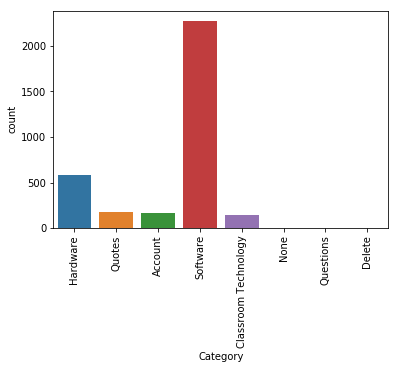

In [24]:
ax = sns.countplot("Category", data = email_df)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

#### Seeing the ratio of each class

In [25]:
email_df["Category"].value_counts()#*100/email_df["Category"].size

Software                2274
Hardware                 586
Quotes                   173
Account                  167
Classroom Technology     141
Questions                  4
None                       3
Delete                     2
Name: Category, dtype: int64

#### Let us look at the indivisual data points of the category with less than 4 samples

In [26]:
gp = email_df.groupby("Category")

In [27]:
gp.get_group("Questions")

,Category,Short Description,Additional Comments,Incident Number,Additional Comments mod,Feature
1476,Questions,Jooble partnership outlook.uttyler.edu,"rma@jooble.jobs\r\n \r\nHello,\r\n \r\nHope y...",0127614,"rma@jooble.jobs Hello, Hope you are doing wel...",Jooble partnership outlook.uttyler.edu rma@jo...
1594,Questions,Verification of student email on various apps,"DRoman@patriots.uttyler.edu\r\n \r\nDear IT,\...",0127977,"Dear IT, My name is David Elias Roman. My st...",Verification of student email on various apps ...
2801,Questions,Student Computers in Room,mizard@uttyler.edu\r\n \r\nCan you tell me if...,0133291,Can you tell me if the student puters have S...,Student Computers in Room Can you tell me i...
3760,Questions,"Read, Write and Goal",AshleyDavis@uttyler.edu\r\n \r\nGood afternoo...,0135744,"Good afternoon IT, The SAR office is purchas...","Read, Write and Goal Good afternoon IT, The ..."


In [28]:
gp.get_group("Delete")

,Category,Short Description,Additional Comments,Incident Number,Additional Comments mod,Feature
1902,Delete,DELETE,fjones@uttyler.edu\r\n \r\nTHIS EMAIL IS FOR ...,0129221,THIS EMAIL IS FOR THOSE WHO ARE INVOLVED IN ...,DELETE THIS EMAIL IS FOR THOSE WHO ARE INVOL...
3214,Delete,DELETE,adennis@uttyler.edu\r\n \r\nAvery Ritzma rece...,0134266,Avery Ritzma received the puter . When she ...,DELETE Avery Ritzma received the puter . Wh...


In [29]:
gp.get_group("None")

,Category,Short Description,Additional Comments,Incident Number,Additional Comments mod,Feature
743,None,Dakota-Request to borrow a monitor temporarily,NaN,0125169,NaN,Dakota-Request to borrow a monitor temporarily
1706,None,Ready for Delivery | Surface Pros for Mathemat...,NaN,0128505,NaN,Ready for Delivery | Surface Pros for Mathemat...
6350,None,email issues,NaN,0141279,NaN,email issues


We can see that the data is heavily imbalanced. This will not favor well for our classification. Categories like "Question", "None", and "Delete" have less than 5 data points. We won't be able to gather any meaning information from so little data points.

As such, we will be removing them entirely and then focus on creating a manual rule for categorizing them later in production.

#### Removing the categories with less than five data points

In [30]:
remove = ["Questions", "Delete", "None"]

In [31]:
for i in remove:
    email_df = email_df.loc[email_df["Category"]!=i]

#### Lets look at the length of all the tickets and see if we can use that as a feature.

In [32]:
email_df["Feature Length"] = email_df["Feature"].str.len()

In [33]:
gk = email_df.groupby("Category")
gk.mean()

,Feature Length
Category,
Account,292.125749
Classroom Technology,440.425532
Hardware,342.158703
Quotes,797.011561
Software,493.954705


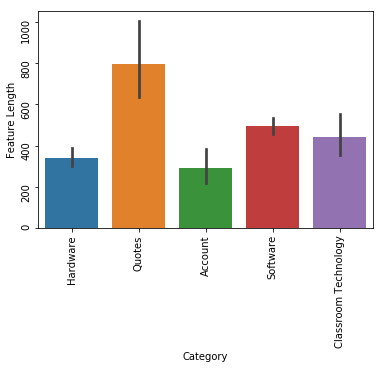

In [34]:
ax = sns.barplot(x = "Category", y = "Feature Length", data = email_df)
ax.tick_params(labelrotation=90)

#### We used length as a feature but there was not any significant results.

## Modeling

#### Converting the classes into numerical representation

In [35]:
dic = {i:j for i, j in zip(email_df["Category"].unique(), range(len(email_df["Category"].unique())))}

In [36]:
num_to_cat_dic = dict([(value, key) for key, value in dic.items()])

In [37]:
email_df["Targets"] = email_df["Category"].map(dic)

#### Looking at our data and seeing where we are.

In [38]:
email_df[["Feature", "Category","Targets"]].head()

,Feature,Category,Targets
41,"Engineering office moves Michael, WE have ...",Hardware,0
42,EVGA UV Plus - Multi-Screen expansion Before...,Quotes,1
44,Printers Please help us disconnect all desk...,Hardware,0
46,Access to previous pliance folders,Account,2
47,Adobe Flash Player installation Good Afterno...,Software,3


#### We will only be using the Feature column for our classification.

In [39]:
X = email_df["Feature"]
y = email_df["Targets"]

In [40]:
X.iloc[20]

'PCs for RBN    Hello, Can we please get a quote for the puter items mentioned below? Thanks, Kristin Kristin Stephens, M.A. Administrative Assistant II Department of Electrical Engineering  University Boulevard \x96 Tyler, Texas  Office ..  [mailto:] Your Success. Our Passion. From: Hassan El-Kishky Sent: Friday, May ,  : AMTo: Kristin Stephens <>Cc: Premananda Indic <>Subject: PCs for RBN  Kristin, Please request a quote for  PCs +  monitors to replace the very old PCs in RBN .  Thanks, h '

#### Spliting the data for training and testing

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [42]:
x_train.head()

884     Quote Request   Can you please get me a quote ...
6700                                         keyboard lag
2685    Office puter Canvas connetion issue   Hi, My o...
1877     Laptops need to be cleaned and given to stora...
2202    Software setup after update   After my update ...
Name: Feature, dtype: object

#### Fitting the CountVectorizer to the training data

In [43]:
vect = TfidfVectorizer(min_df=0.003,max_df=0.5,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [44]:
vect = vect.fit(x_train)

#### We can see how many features we have.

In [45]:
len(vect.get_feature_names())

3563

#### Transforming our training data into a sparse matrix

In [46]:
x_train_vec = vect.transform(x_train)

In [47]:
x_train_vec

<2505x3563 sparse matrix of type '<class 'numpy.float64'>'
	with 107712 stored elements in Compressed Sparse Row format>

In [48]:
x_train_vec.shape

(2505, 3563)

## Classification

#### We will create multiple models and compare there performance.

#### Supervised Learning

In [49]:
logistic_clf = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 0, max_iter = 10000, C = 0.1)

In [50]:
naive_clf = MultinomialNB(alpha=0.1)

In [51]:
svm_clf = svm.SVC(gamma = 1, random_state = 0, kernel = "linear", max_iter = 10000)

In [52]:
knn_clf = KNeighborsClassifier(n_neighbors=30)

In [53]:
rf_clf = RandomForestClassifier(n_estimators=40, max_depth=6,random_state=0)

In [54]:
gb_clf = GradientBoostingClassifier(n_estimators = 25, max_depth = 5, random_state = 0)

In [55]:
clf = [logistic_clf, naive_clf, svm_clf, knn_clf, rf_clf, gb_clf]

clf_dic = ["Logistic", "Naive", "SVM", "KNN", "RandomForest", "GradientBoosting"]

In [56]:
for i in clf:
    i.fit(x_train_vec, y_train)
    print(".", end = "")

......

#### Looking at the f1 score of each classifier

In [57]:
x_test_vec = vect.transform(x_test)
for i,j in zip(clf_dic, clf):
#     print(f"{i} f1: {f1_score(j.predict(x_test_vec), y_test, average = 'weighted')}")
#     print(f"{i}: {precision_score(j.predict(x_test_vec), y_test, average = 'micro')}")
    print(f"{i} accuracy: {j.score(x_test_vec, y_test)}")

Logistic accuracy: 0.7081339712918661
Naive accuracy: 0.7248803827751196
SVM accuracy: 0.7930622009569378
KNN accuracy: 0.6949760765550239
RandomForest accuracy: 0.6949760765550239
GradientBoosting accuracy: 0.7691387559808612


#### We will look at the top features from each of the classifiers

In [58]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        top10 =np.where(top10==feature_names.shape[0], feature_names.shape[0]-1, top10)
#         print(feature_names.shape[0])
        print("%s: %s" % (category, " ".join(feature_names[top10])))

In [59]:
show_top10(logistic_clf, vect, email_df["Category"].unique())

Hardware: connected copier monitor uc scanner printers print monitors disposal printer
Quotes: texas po dell gb need quote pro hp order purchase quote
Account: pick disabled log password pw issue reset employee change account
Software: windows shared login install imagenow drive image software outlook access
Classroom Technology: audio equipment smart board room sound classroom working projector working projector


In [60]:
show_top10(naive_clf, vect, email_df["Category"].unique())

Hardware: uttyler working new texas tyler university need office puter printer
Quotes: hp need office pro texas order university tyler purchase quote
Account: access email log password pw reset employee issue change account
Software: texas uttyler edu edu need office uttyler university tyler puter access
Classroom Technology: cas smart board rbn room sound classroom projector working working projector


### We will ensemble the classifiers and see if that improves the results

In [61]:
clf = [naive_clf, svm_clf, knn_clf, gb_clf]

clf_dic = ["Naive", "SVM", "KNN", "GradientBoosting"]

In [62]:
estimators = list(zip(clf_dic, clf))

In [63]:
ensemble_clf = VotingClassifier(estimators, voting="hard")

In [65]:
ensemble_clf.fit(x_train_vec, y_train)

VotingClassifier(estimators=[('Naive', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
  max_iter=10000, probability=False, random_state=0, shrinking=True,
  tol=0.001, v...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [66]:
ensemble_clf.score(x_test_vec, y_test)

0.7822966507177034

### We got an improvement of ~0.5

### Function that takes in a short description and additional comment to predict the category

In [69]:
def predict(short_description, additional_comments = ""):
    k = f"{short_description} {additional_comments}"
    k = pd.Series([k])
    k = vect.transform(k)
    k = ensemble_clf.predict(k)
    k = num_to_cat_dic[k[0]]
    print(k)

In [70]:
predict("Projector in HRP is not working")

Classroom Technology


In [71]:
predict("Error with One Drive")

Software


In [72]:
predict("Connect my computer to department copier/printer", "I would like to be able to printer to the new Music department copier/printer in FAC 2215")

Hardware


In [73]:
predict("spam in email")

Software


In [74]:
predict("purchase a computer", "Hello I would like to purchase a dell computer")

Quotes


# Further Improvements

### We will now optimize the models. We will use countvectorizer and Tfidf for vectorizing, then proceed with a gridsearch on logistic regression, naivebayes, KNN, SVM, and gradientboosting random forest.

In [76]:
tfidf_vect = TfidfVectorizer(min_df=0.003,max_df=0.5,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


count_vect = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

logistic_clf = LogisticRegression(random_state = 0, max_iter = 10000)
naive_clf = MultinomialNB()
svm_clf = svm.SVC(random_state = 0,max_iter = 10000, gamma = "scale")
knn_clf = KNeighborsClassifier()
gb_clf = GradientBoostingClassifier(random_state = 0)

In [77]:
vect_array = [tfidf_vect, count_vect]
clf_array = [logistic_clf,naive_clf, svm_clf, knn_clf, gb_clf]

In [78]:
clf_dict = {0: "tfidf_logistic", 1:"count_logistic", 2:"tfidf_naive", 3:"count_naive", 4:"tfidf_svm", 5:"count_svm", 6:"tfidf_knn", 7:"count_knn", 8:"tfidf_gb", 9:"count_gb"}

In [79]:
pipe_array = []
for i in clf_array:
    for j in vect_array:
        pipe_array.append(Pipeline([("vect", j), ("clf", i)]))

In [80]:
grid_param_logistic = [{"clf__C": np.logspace(-3, 0, 4), "clf__solver": ["saga", "lbfgs"], "clf__multi_class": ["auto", "multinomial"]}]
grid_param_naive = [{"clf__alpha": np.logspace(-3, 2, 6)}]
grid_param_knn = [{"clf__n_neighbors": np.arange(10, 45, 5)}]
grid_param_gb = [{"clf__n_estimators": np.arange(10, 45, 5), "clf__max_depth": np.arange(2, 15, 2), "clf__learning_rate": np.logspace(-2, 0, 3)}]
grid_param_svm =[{"clf__C": np.logspace(-4, 0, 5), "clf__kernel": ["linear", "poly", "rbf", "sigmoid"]}]

grid_param_array = [grid_param_logistic, grid_param_naive, grid_param_svm, grid_param_knn, grid_param_gb]

In [81]:
jobs = -1
gs_array = []
for i in range(len(pipe_array)):
    gs_array.append(GridSearchCV(estimator = pipe_array[i], param_grid = grid_param_array[int(i/2)], scoring = "accuracy", cv = 5))

In [123]:
for i, gs in enumerate(gs_array):
    if(i>5):
        break;
    print(f"\nEstimator: {clf_dict[i]}")
#     gs.fit(x_train, y_train)
    print(f"Best params: {gs.best_params_}")
    print(f'Best training accuracy: {gs.best_score_}')
    print(f'Test set accuracy score for best params: {gs.score(x_test, y_test)} ')


Estimator: tfidf_logistic
Best params: {'clf__C': 1.0, 'clf__multi_class': 'auto', 'clf__solver': 'saga'}
Best training accuracy: 0.7484444444444445
Test set accuracy score for best params: 0.776 

Estimator: count_logistic
Best params: {'clf__C': 1.0, 'clf__multi_class': 'auto', 'clf__solver': 'saga'}
Best training accuracy: 0.7813333333333333
Test set accuracy score for best params: 0.7906666666666666 

Estimator: tfidf_naive
Best params: {'clf__alpha': 0.1}
Best training accuracy: 0.7173333333333334
Test set accuracy score for best params: 0.7426666666666667 

Estimator: count_naive
Best params: {'clf__alpha': 1.0}
Best training accuracy: 0.7457777777777778
Test set accuracy score for best params: 0.7453333333333333 

Estimator: tfidf_svm
Best params: {'clf__C': 1.0, 'clf__kernel': 'linear'}
Best training accuracy: 0.7826666666666666
Test set accuracy score for best params: 0.7946666666666666 

Estimator: count_svm
Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
Best training

In [82]:
clf_list = []
for i in range(6):
    clf_list.append((clf_dict[i], gs_array[i]))

In [83]:
ensemble_clf = VotingClassifier(clf_list, voting="hard", n_jobs = -1)

In [84]:
ensemble_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('tfidf_logistic', GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lower..._dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None)

In [85]:
ensemble_clf.score(x_test, y_test)

0.7933333333333333